In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

# from sklearn.scale import StandardScaler

## Loading Data

In [2]:
filepath = "laptop_pricing_dataset_base.csv"
df = pd.read_csv(filepath, header=None)
headers = ["Manufacturer", "Category", "Screen", "GPU", "OS", "CPU_core", "Screen_Size_inch", "CPU_frequency", "RAM_GB", "Storage_GB_SSD", "Weight_kg", "Price"]
df.columns = headers
df["Screen_Size_inch"].unique()

array(['35.56', '39.624', '33.782', '38.1', '33.02', '43.942', '43.18',
       '31.75', '30.48', '?'], dtype=object)

In [3]:
df.replace('?',np.NaN, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Manufacturer      238 non-null    object 
 1   Category          238 non-null    int64  
 2   Screen            238 non-null    object 
 3   GPU               238 non-null    int64  
 4   OS                238 non-null    int64  
 5   CPU_core          238 non-null    int64  
 6   Screen_Size_inch  234 non-null    object 
 7   CPU_frequency     238 non-null    float64
 8   RAM_GB            238 non-null    int64  
 9   Storage_GB_SSD    238 non-null    int64  
 10  Weight_kg         233 non-null    object 
 11  Price             238 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 22.4+ KB


## Dealing Missing Values

In [4]:
mean_screen = df["Screen_Size_inch"].astype("float64").mean(axis=0)
mean_weight = df["Weight_kg"].astype("float64").mean(axis=0)
df.replace({"Screen_Size_inch":{np.nan: mean_screen}, "Weight_kg":{np.nan: mean_weight}}, inplace=True)
df[["Screen_Size_inch", "Weight_kg"]] = df[["Screen_Size_inch", "Weight_kg"]].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Manufacturer      238 non-null    object 
 1   Category          238 non-null    int64  
 2   Screen            238 non-null    object 
 3   GPU               238 non-null    int64  
 4   OS                238 non-null    int64  
 5   CPU_core          238 non-null    int64  
 6   Screen_Size_inch  238 non-null    float64
 7   CPU_frequency     238 non-null    float64
 8   RAM_GB            238 non-null    int64  
 9   Storage_GB_SSD    238 non-null    int64  
 10  Weight_kg         238 non-null    float64
 11  Price             238 non-null    int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 22.4+ KB


In [5]:
df["Screen_Size_inch"] = df["Screen_Size_inch"].round(2)
df.head()

,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,Acer,4,IPS Panel,2,1,5,35.56,1.6,8,256,1.60,978
1,Dell,3,Full HD,1,1,3,39.62,2.0,4,256,2.20,634
2,Dell,3,Full HD,1,1,7,39.62,2.7,8,256,2.20,946
3,Dell,4,IPS Panel,2,1,5,33.78,1.6,8,128,1.22,1244
4,HP,4,Full HD,2,1,7,39.62,1.8,8,256,1.91,837


## Normalization

In [7]:
scaler = MinMaxScaler()
df[['Screen_Size_inch', 'CPU_frequency', 'Weight_kg']] = scaler.fit_transform(df[['Screen_Size_inch', 'CPU_frequency', 'Weight_kg']])
df.head()

,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,Acer,4,IPS Panel,2,1,5,0.377415,0.235294,8,256,0.283154,978
1,Dell,3,Full HD,1,1,3,0.679049,0.470588,4,256,0.498208,634
2,Dell,3,Full HD,1,1,7,0.679049,0.882353,8,256,0.498208,946
3,Dell,4,IPS Panel,2,1,5,0.245171,0.235294,8,128,0.146953,1244
4,HP,4,Full HD,2,1,7,0.679049,0.352941,8,256,0.394265,837


## Binning

<BarContainer object of 3 artists>

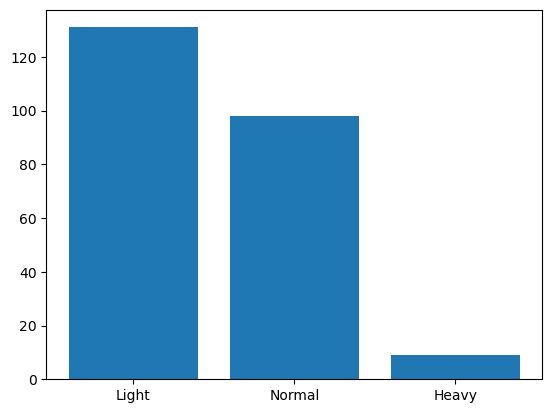

In [8]:
bins = np.linspace(min(df["Weight_kg"]), max(df["Weight_kg"]), 4)
labels = ["Light", "Normal", "Heavy"]
df["Binned_Weight_kg"] = pd.cut(df["Weight_kg"], labels=labels, bins=bins, include_lowest=True)
plt.bar(labels, df["Binned_Weight_kg"].value_counts())

(array([ 46.,  91., 101.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

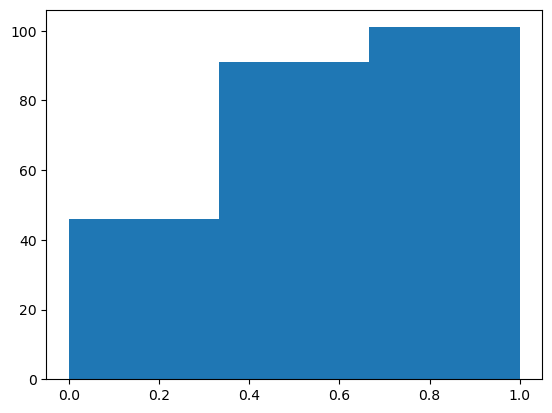

In [9]:
plt.hist(df["Screen_Size_inch"], bins=3)

<Axes: xlabel='Screen_Size_inch', ylabel='Price'>

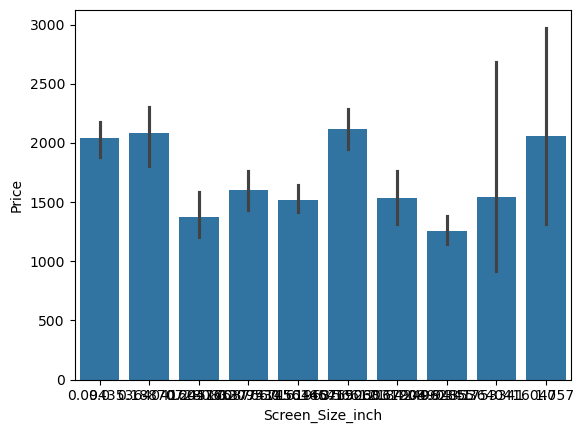

In [10]:
df1 = df[["Screen_Size_inch", "Price"]]
df2= df1.groupby("Screen_Size_inch", as_index=False).mean()
sns.barplot(x='Screen_Size_inch', y='Price', data=df)

<Axes: xlabel='Binned_Weight_kg', ylabel='Price'>

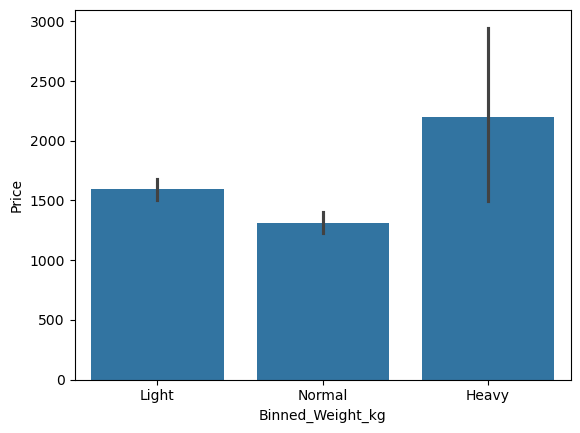

In [11]:
df1 = df[["Binned_Weight_kg", "Price"]]
df2= df1.groupby("Binned_Weight_kg", as_index=False).mean()
sns.barplot(x='Binned_Weight_kg', y='Price', data=df)

In [12]:
df["Screen"].unique()

array(['IPS Panel', 'Full HD'], dtype=object)

In [13]:
dummy1= pd.get_dummies(df["Screen"])
df = pd.concat([df, dummy1], axis=1)
df[["Full HD", "IPS Panel"]] = df[["Full HD", "IPS Panel"]].astype("int64")
df.head()

,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price,Binned_Weight_kg,Full HD,IPS Panel
0,Acer,4,IPS Panel,2,1,5,0.377415,0.235294,8,256,0.283154,978,Light,0,1
1,Dell,3,Full HD,1,1,3,0.679049,0.470588,4,256,0.498208,634,Normal,1,0
2,Dell,3,Full HD,1,1,7,0.679049,0.882353,8,256,0.498208,946,Normal,1,0
3,Dell,4,IPS Panel,2,1,5,0.245171,0.235294,8,128,0.146953,1244,Light,0,1
4,HP,4,Full HD,2,1,7,0.679049,0.352941,8,256,0.394265,837,Normal,1,0


## Correlation

In [14]:
df_num = df._get_numeric_data()
df_num.corr()["Price"].sort_values()

OS                 -0.221730
Screen_Size_inch   -0.126568
Weight_kg          -0.050312
Full HD            -0.021075
IPS Panel           0.021075
Storage_GB_SSD      0.243421
Category            0.286243
GPU                 0.288298
CPU_frequency       0.366666
CPU_core            0.459398
RAM_GB              0.549297
Price               1.000000
Name: Price, dtype: float64

(0.0, 3974.15)

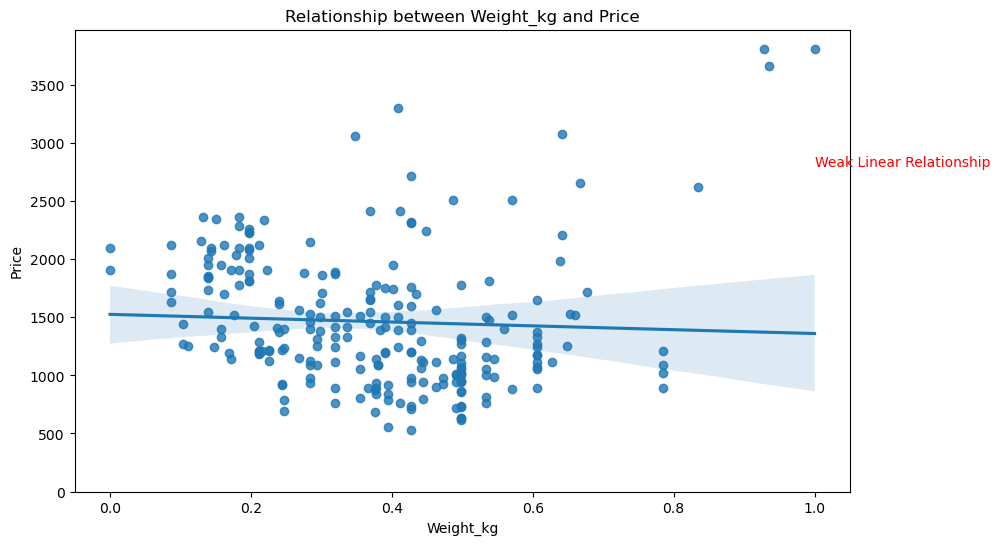

In [15]:
plt.figure(figsize=(10,6))
sns.regplot(x=df["Weight_kg"], y=df["Price"])
plt.title("Relationship between Weight_kg and Price")
plt.text(1, 2800, "Weak Linear Relationship", color="red")
plt.ylim(0,)

<Axes: xlabel='RAM_GB', ylabel='Price'>

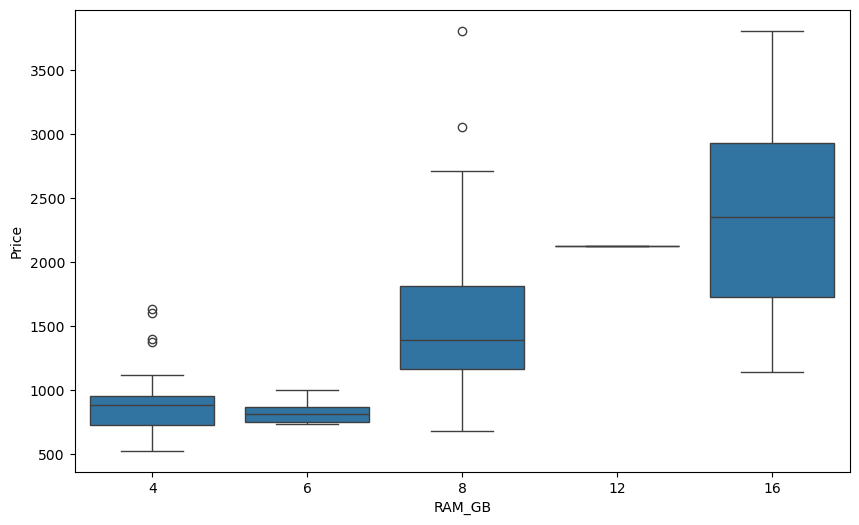

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df["RAM_GB"], y=df["Price"])

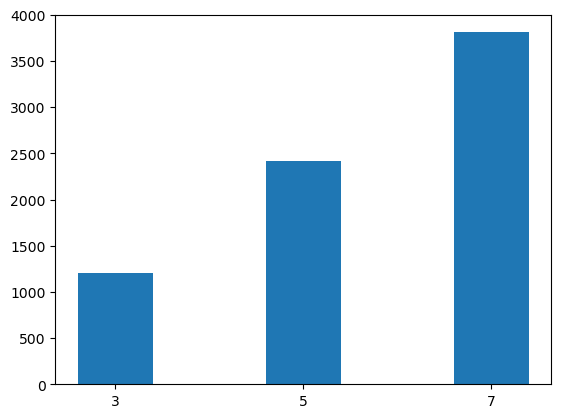

In [17]:
plt.bar(df["CPU_core"], df["Price"])
plt.xticks(ticks=[3,5,7])
plt.show()

<Axes: xlabel='Screen', ylabel='Price'>

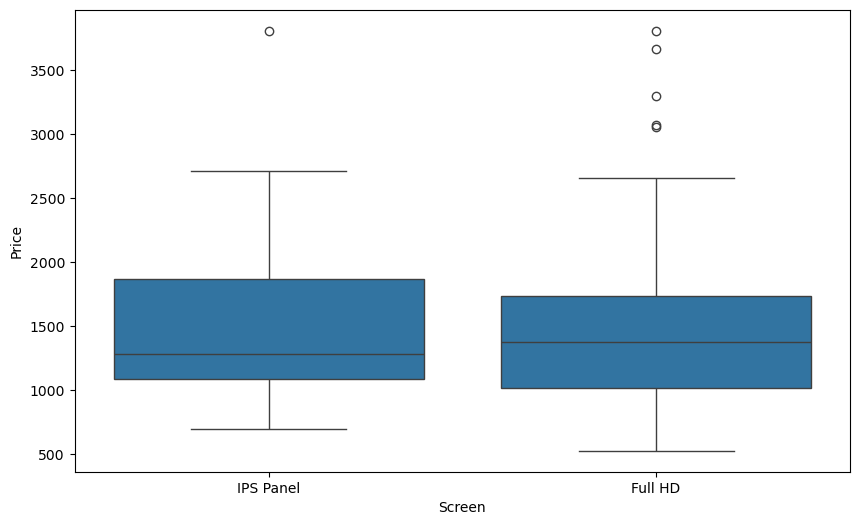

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df["Screen"], y=df["Price"])

<Axes: xlabel='CPU_frequency', ylabel='Price'>

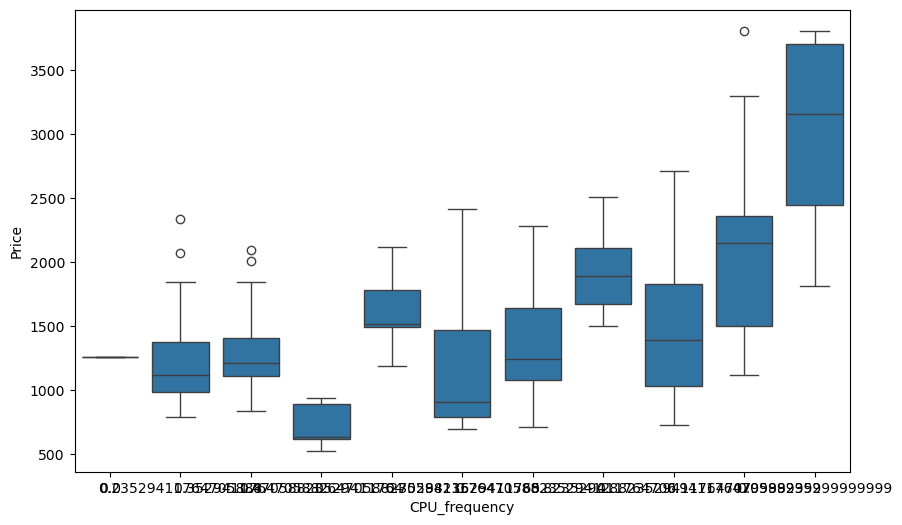

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df["CPU_frequency"], y=df["Price"])

<Axes: xlabel='GPU', ylabel='Price'>

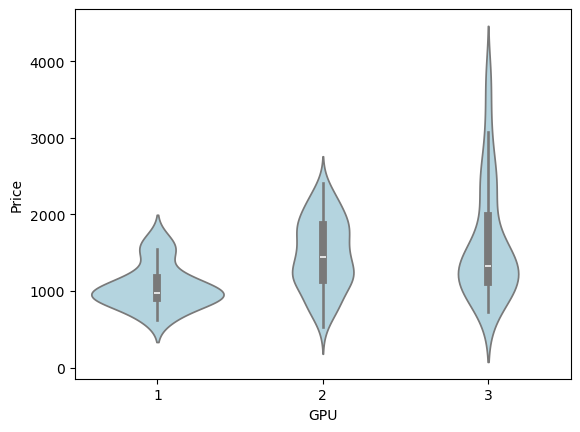

In [20]:
sns.violinplot(x="GPU", y="Price", data=df, color="lightblue")

In [21]:
df["Category"].value_counts()

Category
3    154
4     60
1     14
5      9
2      1
Name: count, dtype: int64

<BarContainer object of 238 artists>

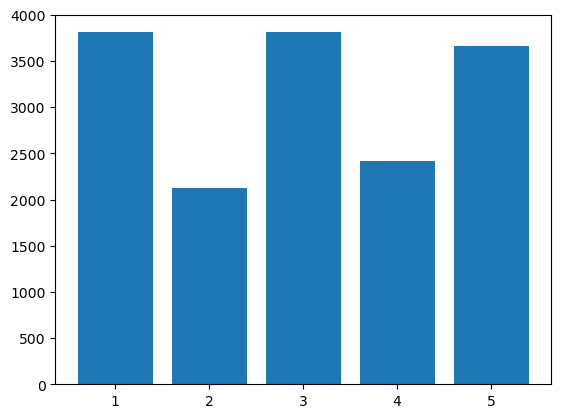

In [22]:
plt.bar(df["Category"], df["Price"])

In [23]:
df3= df[["Manufacturer", "Screen", "Price"]]
df3 = df3.groupby(["Manufacturer", "Screen"], as_index=False).mean()
df3 = df3.pivot(index="Manufacturer", columns="Screen").round(2).fillna(0)
df3

Price          
Screen        Full HD IPS Panel
Manufacturer                   
Acer          1159.00   1034.36
Asus          1335.81   1257.50
Dell          1461.15   1728.89
HP            1432.22   1230.50
Huawei           0.00   1714.00
Lenovo        1294.05   1617.50
MSI           1452.75      0.00
Razer         3301.00      0.00
Samsung       2107.40      0.00
Toshiba       1726.00   1688.40
Xiaomi           0.00   1188.00

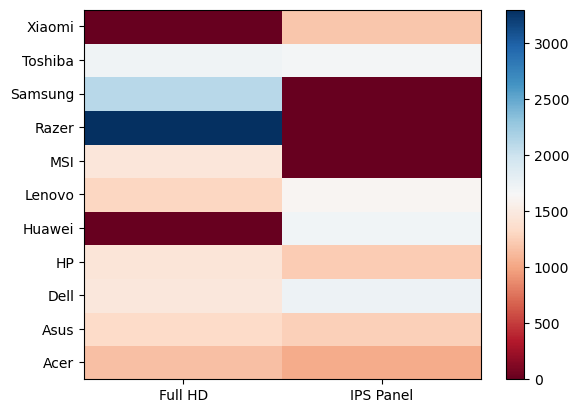

In [24]:
plt.pcolor(df3, cmap="RdBu")
plt.xticks(ticks=[0.5, 1.5], labels=df3.columns.levels[1])
plt.yticks(ticks=np.arange(0.5,11), labels=df3.index)
plt.colorbar()
plt.show()

In [25]:
for i in df_num.columns.values.tolist():
    c, p= stats.pearsonr(df[i], df["Price"])
    print(f"{i}\nCoef:{c}\nP-value:{p}\n")

Category
Coef:0.28624275581264125
P-value:7.225696235806733e-06

GPU
Coef:0.2882981988881428
P-value:6.166949698364282e-06

OS
Coef:-0.22172980114827381
P-value:0.0005696642559246749

CPU_core
Coef:0.45939777733551157
P-value:7.912950127009034e-14

Screen_Size_inch
Coef:-0.12656814164825458
P-value:0.05115611987900375

CPU_frequency
Coef:0.366665558925886
P-value:5.5024633507134225e-09

RAM_GB
Coef:0.5492972971857842
P-value:3.6815606288429613e-20

Storage_GB_SSD
Coef:0.2434207552181029
P-value:0.00014898923191724174

Weight_kg
Coef:-0.050312258377515434
P-value:0.43976938534338944

Price
Coef:1.0
P-value:0.0

Full HD
Coef:-0.021074572471421627
P-value:0.7463568309776384

IPS Panel
Coef:0.021074572471421634
P-value:0.7463568309776384



## Single Linear Regression (RAM_GB)

In [27]:
y_data = df["Price"]
x_data = df.drop("Price", axis=1)
lm = LinearRegression()

In [28]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(x_data[["RAM_GB"]], y_data, test_size=0.45, random_state=0)
lm.fit(x_train0, y_train0)
Yhat0 = lm.predict(x_test0)

lm.score(x_test0, y_test0), lm.score(x_train0, y_train0), mean_squared_error(y_test0, Yhat0)

(0.30335806126556353, 0.29866935497711244, 203438.36056024057)

<Axes: xlabel='RAM_GB', ylabel='Price'>

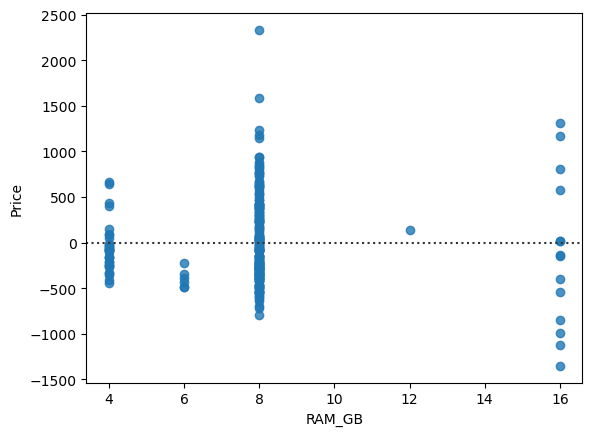

In [29]:
sns.residplot(x=df["RAM_GB"], y=df["Price"])

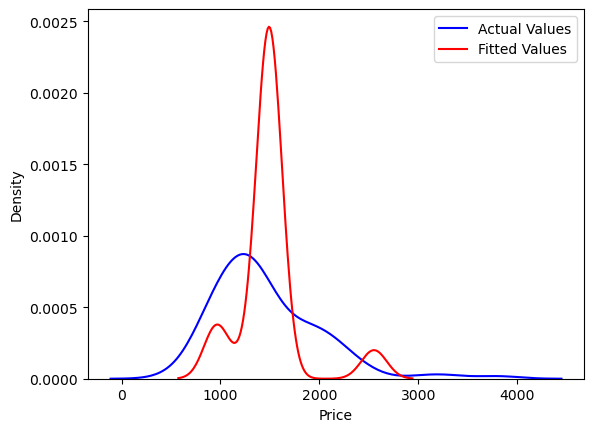

In [30]:
ax1=sns.kdeplot(y_test0, color="b", label="Actual Values")
sns.kdeplot(Yhat0, color="r", label="Fitted Values", ax=ax1)
plt.legend()

## Multiple Linear Regression (CPU_core, RAM_GB, CPU_frequency)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_data[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU', 'Category']], y_data, test_size=0.45, random_state=1)
lm.fit(x_train, y_train)
Yhat = lm.predict(x_test)
lm.score(x_test, y_test), lm.score(x_train, y_train), mean_squared_error(y_test, Yhat)

(0.4056176950494681, 0.5282421465289736, 142063.63691810198)

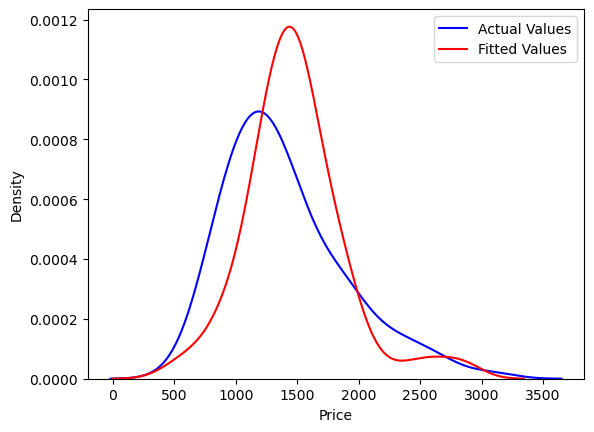

In [33]:
ax1=sns.kdeplot(y_test, color="b", label="Actual Values")
sns.kdeplot(Yhat, color="r", label="Fitted Values", ax=ax1)
plt.legend()

## Multiple Linear Regression + Polynomial Features (Degree=2)

In [35]:
pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
lm.fit(x_train_pr, y_train)
Yhat_pr= lm.predict(x_test_pr)
lm.score(x_test_pr, y_test), lm.score(x_train_pr, y_train), mean_squared_error(y_test, Yhat_pr)

(0.48103534851549, 0.6603799251974782, 124038.0226796299)

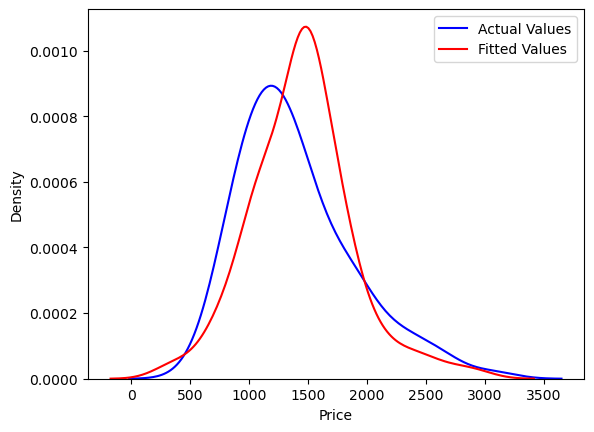

In [36]:
ax1=sns.kdeplot(y_test, color="b", label="Actual Values")
sns.kdeplot(Yhat_pr, color="r", label="Fitted Values", ax=ax1)
plt.legend()

## Single Linear Regression + Polynomial(degree=2)

In [38]:
pr=PolynomialFeatures(degree=3)
x_train_pr0 = pr.fit_transform(x_train0)
x_test_pr0 = pr.fit_transform(x_test0)
lm.fit(x_train_pr0, y_train0)
Yhat0_pr= lm.predict(x_test_pr0)
lm.score(x_test_pr0, y_test0), lm.score(x_train_pr0, y_train0), mean_squared_error(y_test0, Yhat0_pr)

(0.30451100335491965, 0.3170771948640835, 203101.67016674287)

## Overfitting

[40.561769504946746, 48.103534851549, -724.0569275847879]


Text(0, 0.5, 'R^2')

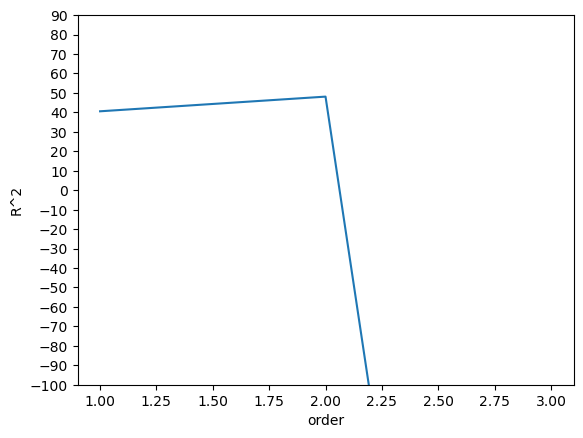

In [40]:
order = [1, 2, 3]
r2 = []

for i in order:
    pr = PolynomialFeatures(degree=i)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    lm.fit(x_train_pr, y_train)
    x = 100 * lm.score(x_test_pr, y_test)
    r2.append(x)

print(r2)
sns.lineplot(x=order, y=r2)
plt.yticks(ticks=range(-100,100, 10))
plt.ylim(-100,)
plt.xlabel('order')
plt.ylabel('R^2')

## Pipeline

In [42]:
Input=[("scale",StandardScaler()), ("polynomial", PolynomialFeatures(include_bias=False, degree=2)), ("model", LinearRegression())]
pipe= Pipeline(Input)
x_train = x_train.astype("float64")
pipe.fit(x_train, y_train)
Yhat_pipe = pipe.predict(x_test)
pipe.score(x_train, y_train), pipe.score(x_test, y_test), mean_squared_error(y_test, Yhat_pipe)

(0.6603800479794011, -3.2264855070155984e+20, 7.711640500945433e+25)

## cross-val-score

In [44]:
rcross = cross_val_score(lm, x_data[["CPU_core", "RAM_GB", "CPU_frequency", 'Storage_GB_SSD', 'OS','GPU', 'Category']], y_data, cv=7)
rcross.mean()

0.3189541421947883

In [45]:
poly = PolynomialFeatures(degree=2)
x_data_pr = poly.fit_transform(x_data[["CPU_core", "RAM_GB", "CPU_frequency", 'Storage_GB_SSD', 'Category']])
rcross = cross_val_score(lm, x_data_pr, y_data, cv=6)
rcross.mean()

0.3169269162149811

## Ridge

In [47]:
RR = Ridge()
params = [{"alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
grid = GridSearchCV(RR, params, cv=4)
pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
grid.fit(x_train_pr, y_train)
bestrr = grid.best_estimator_
bestrr

Ridge(alpha=1000)

In [48]:
yhat=bestrr.predict(x_test_pr)
bestrr.score(x_test_pr, y_test)

0.43941617489879514

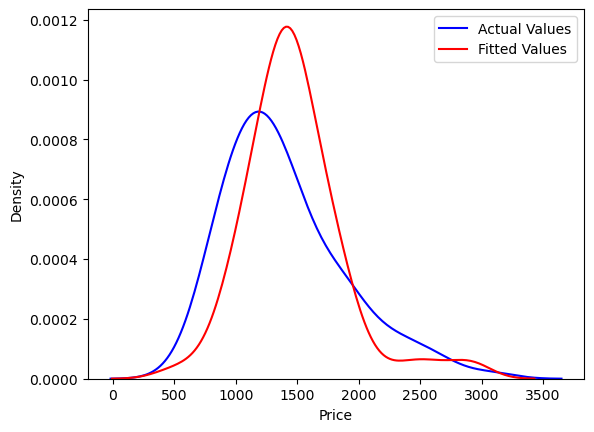

In [88]:
ax1=sns.kdeplot(y_test, color="b", label="Actual Values")
sns.kdeplot(yhat, color="r", label="Fitted Values", ax=ax1)
plt.legend()

In [145]:
pr = PolynomialFeatures(degree = 2)
x_train_pr1 = pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
x_test_pr1 = pr.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])

In [122]:
alpha = np.arange(0.01, 100, 0.1)
r2_train, r2_test = [], []
bar = tqdm(alpha) #array of alpha

# The difference is that without tqdm (by just alpha instead of bar here),
# you won't have the visual progress bar showing the progress of the iteration.
for i in bar:
    RR = Ridge(alpha=i)
    RR.fit(x_train_pr, y_train)
    
    test_score = RR.score(x_test_pr, y_test)
    train_score = RR.score(x_train_pr, y_train)
    r2_train.append(train_score)
    r2_test.append(test_score)

    bar.set_postfix({"Test Score": test_score, "Train Score": train_score, "Alpha": i})
    if test_score == max(r2_test):
        x = i
print(x)

100%|██████████| 1000/1000 [00:04<00:00, 227.79it/s, Test Score=0.491, Train Score=0.598, Alpha=99.9]

13.31


In [126]:
RR = Ridge(alpha=13.31)
RR.fit(x_train_pr, y_train)

(0.5161129687758155, 0.6250394370234262)

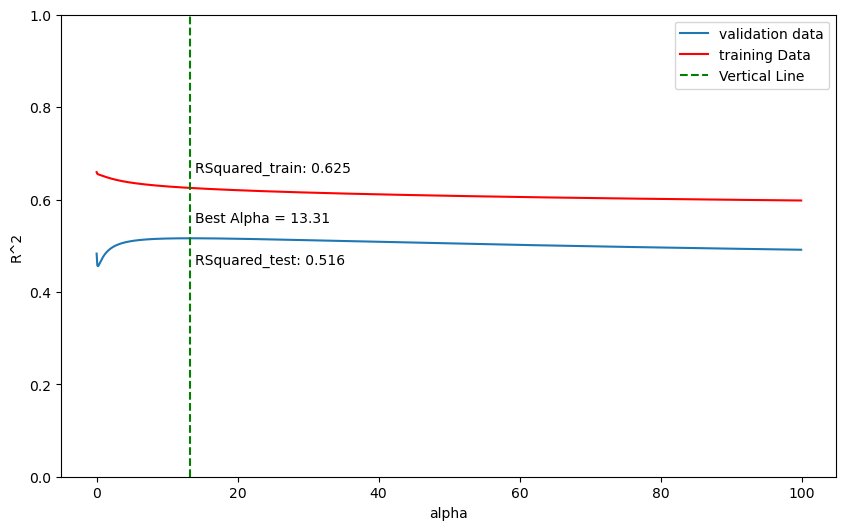

In [148]:
plt.figure(figsize=(10, 6))  
plt.plot(alpha, r2_test, label='validation data')
plt.plot(alpha, r2_train, 'r', label='training Data')
plt.text(14, 0.55, "Best Alpha = 13.31")
plt.text(14, 0.66, f"RSquared_train: {RR.score(x_train_pr, y_train).round(3)}")
plt.text(14, 0.46, f"RSquared_test: {RR.score(x_test_pr, y_test).round(3)}")
# plt.plot(13.31, 0.5161129687758155, 'ro', label='Marker')
plt.axvline(x=13.31, color='g', linestyle='--', label='Vertical Line')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0, 1)
plt.legend()